In [50]:
import os
import time
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as m
from catboost import CatBoostClassifier, Pool

# Datasets

In [51]:
# получение путей к файлам
tiff_files = []
csv_files = []
directory = 'data/train'
for root, dirs, files in os.walk(directory, topdown = False):
   for file in files:
        if os.path.splitext(file)[1] == '.tiff':
            tiff_files.append(os.path.join(root, file))
        if os.path.splitext(file)[1] == '.csv':
            csv_files.append(os.path.join(root, file))    

In [52]:
%%time
# формирование тренировочного датасета
list_of_df = []
for file_tiff, file_csv in zip(tiff_files, csv_files):
    with rasterio.open(file_tiff) as src:
        df = pd.DataFrame(src.read(5).reshape(-1, 1))
        df.columns = ['target']
        for i in range(1, 5):
            df[f'band{i}'] = src.read(i).reshape(-1, 1)
        df_csv = pd.read_csv(file_csv)
        df_csv.columns = ['date', 't_min', 't_avg', 't_max', 'rains', 'wind_way', 'wind_speed', 'wind_s', 'pressure']
        for i, j in enumerate(df_csv['t_max'].tolist()):
            df[f't_max_day{-62 + i}'] = j 
        for i, j in enumerate(df_csv['wind_way'].tolist()[-10:]):
            df[f't_wind_way_day{-10 + i}'] = j
        for i, j in enumerate(df_csv['wind_speed'].tolist()[-10:]):
            df[f't_win_speed_day{-10 + i}'] = j  
        for i, j in enumerate(df_csv['pressure'].tolist()[-10:]):
            df[f't_pressure_day{-10 + i}'] = j   
        list_of_df.append(df)




df_train = list_of_df[1]
for df in list_of_df[2:-1]:
    df_train = pd.concat([df_train, df])
df_train.reset_index(drop=True, inplace=True)   

df_valid = list_of_df[0]
df_valid.reset_index(drop=True, inplace=True)  

df_test = list_of_df[-1]
df_test.reset_index(drop=True, inplace=True)   

CPU times: user 3.11 s, sys: 737 ms, total: 3.85 s
Wall time: 3.85 s


In [53]:
df_test

,target,band1,band2,band3,band4,t_max_day-62,t_max_day-61,t_max_day-60,t_max_day-59,t_max_day-58,...,t_pressure_day-10,t_pressure_day-9,t_pressure_day-8,t_pressure_day-7,t_pressure_day-6,t_pressure_day-5,t_pressure_day-4,t_pressure_day-3,t_pressure_day-2,t_pressure_day-1
0,0.0,16.0,19.0,21.0,32.0,2.5,-0.5,-5.8,-11.5,-15.4,...,1024.2,1022.8,1023.5,1035.2,1040.4,1033.8,1037.4,1031.9,1024.3,1019.3
1,0.0,9.0,11.0,17.0,26.0,2.5,-0.5,-5.8,-11.5,-15.4,...,1024.2,1022.8,1023.5,1035.2,1040.4,1033.8,1037.4,1031.9,1024.3,1019.3
2,0.0,8.0,10.0,15.0,23.0,2.5,-0.5,-5.8,-11.5,-15.4,...,1024.2,1022.8,1023.5,1035.2,1040.4,1033.8,1037.4,1031.9,1024.3,1019.3
3,0.0,7.0,9.0,13.0,20.0,2.5,-0.5,-5.8,-11.5,-15.4,...,1024.2,1022.8,1023.5,1035.2,1040.4,1033.8,1037.4,1031.9,1024.3,1019.3
4,0.0,6.0,8.0,11.0,18.0,2.5,-0.5,-5.8,-11.5,-15.4,...,1024.2,1022.8,1023.5,1035.2,1040.4,1033.8,1037.4,1031.9,1024.3,1019.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637787,0.0,33.0,38.0,48.0,67.0,2.5,-0.5,-5.8,-11.5,-15.4,...,1024.2,1022.8,1023.5,1035.2,1040.4,1033.8,1037.4,1031.9,1024.3,1019.3
1637788,0.0,29.0,34.0,42.0,62.0,2.5,-0.5,-5.8,-11.5,-15.4,...,1024.2,1022.8,1023.5,1035.2,1040.4,1033.8,1037.4,1031.9,1024.3,1019.3
1637789,0.0,21.0,26.0,36.0,57.0,2.5,-0.5,-5.8,-11.5,-15.4,...,1024.2,1022.8,1023.5,1035.2,1040.4,1033.8,1037.4,1031.9,1024.3,1019.3
1637790,0.0,18.0,23.0,31.0,52.0,2.5,-0.5,-5.8,-11.5,-15.4,...,1024.2,1022.8,1023.5,1035.2,1040.4,1033.8,1037.4,1031.9,1024.3,1019.3


In [54]:
df_train.shape  

(2844540, 97)

In [55]:
df_valid.shape

(44376, 97)

In [56]:
df_test.shape

(1637792, 97)

In [57]:
X_train = df_train.drop(['target'], axis=1)
y_train = df_train['target']

X_valid = df_valid.drop(['target'], axis=1)
y_valid = df_valid['target']

X_test = df_test.drop(['target'], axis=1)
y_test = df_test['target']

# Model

In [58]:
train_pool = Pool(
        X_train, 
        y_train, 
    )
valid_pool = Pool(
        X_valid, 
        y_valid, 
    )

In [59]:
%%time
clf = CatBoostClassifier(random_state=42,
                         task_type='GPU',
                         learning_rate=0.005,
                         iterations=1400,
                         eval_metric='AUC'
                        )
clf.fit(train_pool, eval_set=valid_pool, verbose=200, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5330737	best: 0.5330737 (0)	total: 27.5ms	remaining: 38.5s
200:	test: 0.7535456	best: 0.7536066 (195)	total: 4.31s	remaining: 25.7s
400:	test: 0.7391584	best: 0.7596301 (315)	total: 8.64s	remaining: 21.5s
600:	test: 0.7632509	best: 0.7653568 (565)	total: 13s	remaining: 17.2s
800:	test: 0.7632500	best: 0.7653568 (565)	total: 17.2s	remaining: 12.9s
1000:	test: 0.7661292	best: 0.7661292 (1000)	total: 21.5s	remaining: 8.56s
1200:	test: 0.7704992	best: 0.7704992 (1200)	total: 25.7s	remaining: 4.26s
1399:	test: 0.7715413	best: 0.7716393 (1330)	total: 29.9s	remaining: 0us
bestTest = 0.7716393471
bestIteration = 1330
Shrink model to first 1331 iterations.
CPU times: user 51.3 s, sys: 8.25 s, total: 59.6 s
Wall time: 31.1 s


In [60]:
print(f'ROC_AUC {m.roc_auc_score(y_valid, clf.predict_proba(X_valid)[:,1]):2.5f}')

ROC_AUC 0.77164


In [61]:
print(f'ROC_AUC {m.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]):2.5f}')

ROC_AUC 0.80292


# Predict

In [62]:
# указать пути к тестовым файлам 
with rasterio.open(tiff_files[-1]) as src:
        test_shape = (src.read(1).shape)
        df = pd.DataFrame(src.read(1).reshape(-1, 1))
        df.columns = ['band1']
        for i in range(2, 5):
            df[f'band{i}'] = src.read(i).reshape(-1, 1)
        df_csv = pd.read_csv(csv_files[-1])
        df_csv.columns = ['date', 't_min', 't_avg', 't_max', 'rains', 'wind_way', 'wind_speed', 'wind_s', 'pressure']
        for i, j in enumerate(df_csv['t_max'].tolist()):
            df[f't_max_day{-62 + i}'] = j 
        for i, j in enumerate(df_csv['wind_way'].tolist()[-10:]):
            df[f't_wind_way_day{-10 + i}'] = j
        for i, j in enumerate(df_csv['wind_speed'].tolist()[-10:]):
            df[f't_win_speed_day{-10 + i}'] = j  
        for i, j in enumerate(df_csv['pressure'].tolist()[-10:]):
            df[f't_pressure_day{-10 + i}'] = j   
        
        
df

,band1,band2,band3,band4,t_max_day-62,t_max_day-61,t_max_day-60,t_max_day-59,t_max_day-58,t_max_day-57,...,t_pressure_day-10,t_pressure_day-9,t_pressure_day-8,t_pressure_day-7,t_pressure_day-6,t_pressure_day-5,t_pressure_day-4,t_pressure_day-3,t_pressure_day-2,t_pressure_day-1
0,16.0,19.0,21.0,32.0,2.5,-0.5,-5.8,-11.5,-15.4,-17.2,...,1024.2,1022.8,1023.5,1035.2,1040.4,1033.8,1037.4,1031.9,1024.3,1019.3
1,9.0,11.0,17.0,26.0,2.5,-0.5,-5.8,-11.5,-15.4,-17.2,...,1024.2,1022.8,1023.5,1035.2,1040.4,1033.8,1037.4,1031.9,1024.3,1019.3
2,8.0,10.0,15.0,23.0,2.5,-0.5,-5.8,-11.5,-15.4,-17.2,...,1024.2,1022.8,1023.5,1035.2,1040.4,1033.8,1037.4,1031.9,1024.3,1019.3
3,7.0,9.0,13.0,20.0,2.5,-0.5,-5.8,-11.5,-15.4,-17.2,...,1024.2,1022.8,1023.5,1035.2,1040.4,1033.8,1037.4,1031.9,1024.3,1019.3
4,6.0,8.0,11.0,18.0,2.5,-0.5,-5.8,-11.5,-15.4,-17.2,...,1024.2,1022.8,1023.5,1035.2,1040.4,1033.8,1037.4,1031.9,1024.3,1019.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637787,33.0,38.0,48.0,67.0,2.5,-0.5,-5.8,-11.5,-15.4,-17.2,...,1024.2,1022.8,1023.5,1035.2,1040.4,1033.8,1037.4,1031.9,1024.3,1019.3
1637788,29.0,34.0,42.0,62.0,2.5,-0.5,-5.8,-11.5,-15.4,-17.2,...,1024.2,1022.8,1023.5,1035.2,1040.4,1033.8,1037.4,1031.9,1024.3,1019.3
1637789,21.0,26.0,36.0,57.0,2.5,-0.5,-5.8,-11.5,-15.4,-17.2,...,1024.2,1022.8,1023.5,1035.2,1040.4,1033.8,1037.4,1031.9,1024.3,1019.3
1637790,18.0,23.0,31.0,52.0,2.5,-0.5,-5.8,-11.5,-15.4,-17.2,...,1024.2,1022.8,1023.5,1035.2,1040.4,1033.8,1037.4,1031.9,1024.3,1019.3


In [63]:
test_shape

(992, 1651)

In [96]:
res = clf.predict_proba(df)[:,1]
res

array([0.19468929, 0.26938449, 0.33013778, ..., 0.29473096, 0.30033243,
       0.29758932])

In [97]:
res = np.array([1 if i > 0.45 else 0 for i in res ]).reshape(test_shape) # порог сам придумал, с 0.5 только 6 точек показал :)
res # собствено предсказанный 5-й слой

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [66]:
res.shape

(992, 1651)

In [71]:
# визуализация изображения
def visualize_rgb_geotiff(file_path, r_band, g_band, b_band, ik_band, mask_band, photo_laer: str):
    try:
        with rasterio.open(file_path) as src:
            num_bands = src.count
            print(f"Number of bands: {num_bands}")
            red = src.read(r_band)  # B02 - Blue
            green = src.read(g_band)  # B03 - Green
            blue = src.read(b_band)  # B04 - Red
            ik = src.read(ik_band)
            mask = src.read(mask_band)

            if photo_laer == "full":
                photo = np.stack([red, green, blue], axis=-1)  # Отрисовка всего изображения
            elif photo_laer == "ik_laer":
                photo = np.stack([ik], axis=-1) # Отрисовка ИК-слоя изображения
            elif photo_laer == "mask_laer":
                photo = np.stack([mask], axis=-1)  # Отрисовка маски изображения
            photo = photo.astype(np.uint8)
            fig, ax = plt.subplots(figsize=(10, 10))
            ax.imshow(photo)
            ax.axis('off')
            plt.show()
    except Exception as e:
        print(f'Ошибка: {e}')

## Оригинальная маска из 20 изображения

Number of bands: 5


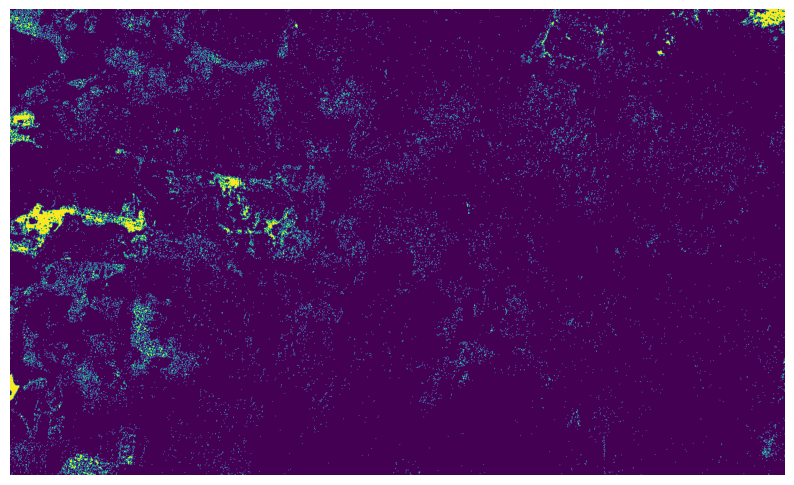

In [72]:
visualize_rgb_geotiff(tiff_files[-1], 1, 2, 3, 4, 5, "mask_laer")

## Предсказанная маска

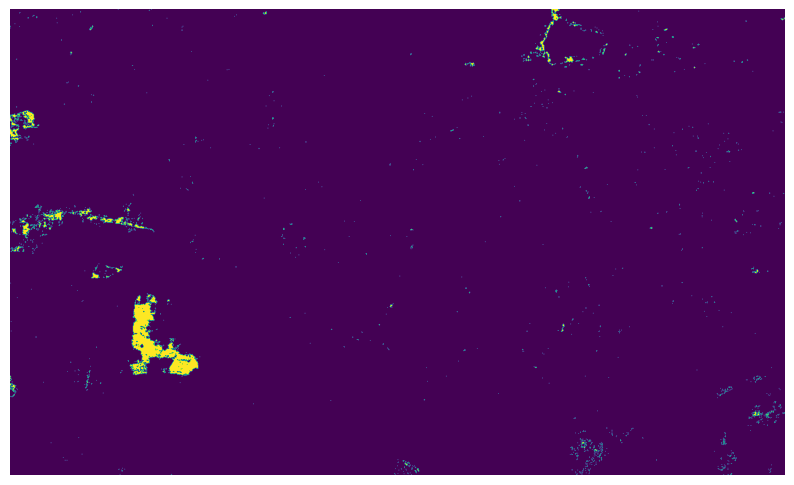

In [98]:
photo = np.stack([res], axis=-1)
photo = photo.astype(np.uint8)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(photo)
ax.axis('off')
plt.show()

# Обучение модели на всех данных для деплоя 

In [21]:
df_train = list_of_df[0]
for df in list_of_df[1:]:
    df_train = pd.concat([df_train, df])
df_train.reset_index(drop=True, inplace=True)

In [22]:
X = df_train.drop(['target'], axis=1)
y = df_train['target']

In [23]:
train_pool = Pool(X, y)

In [24]:
%%time
clf = CatBoostClassifier(random_state=42,
                         task_type='GPU',
                         learning_rate=0.005,
                         iterations=1400
                        )
clf.fit(train_pool, verbose=200, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6849929	total: 36.5ms	remaining: 51s
200:	learn: 0.1938174	total: 6.77s	remaining: 40.4s
400:	learn: 0.1596477	total: 13.7s	remaining: 34.1s
600:	learn: 0.1525994	total: 20.6s	remaining: 27.4s
800:	learn: 0.1494955	total: 27.4s	remaining: 20.5s
1000:	learn: 0.1473818	total: 34.2s	remaining: 13.6s
1200:	learn: 0.1457815	total: 41s	remaining: 6.79s
1399:	learn: 0.1444553	total: 47.8s	remaining: 0us
CPU times: user 1min 21s, sys: 13.5 s, total: 1min 34s
Wall time: 49.7 s


In [99]:
clf.save_model("firemlmodel_v1.json", format="json", export_parameters=None, pool=None)